In [1]:
!pip install fsspec catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 5.0 MB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [53]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import warnings
import numpy as np
import dask.dataframe as dd
import os
import itertools
import matplotlib.ticker as ticker
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from google.colab import drive
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier

drive.mount('/content/drive', force_remount=True)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
alt.renderers.enable('default')
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')
sns.set_palette(sns.color_palette("Set3"))

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ml_projects/churn_prediction/final_masterTable.csv')

In [4]:
df.groupby('date_pred')['is_churn'].value_counts().to_frame('count_churn')

count_churn
date_pred is_churn             
201701    0              828403
          1               39126
201702    0              929460
          1               63471
201703    0              883630
          1               87330
201704    0              907471

In [5]:
df.fillna(0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
sample_train = df[df.date_pred == 201701].sample(frac=0.25, random_state=0).reset_index(drop=True)

In [7]:
dfMasterTable = pd.concat([sample_train, df[df.date_pred >= 201702]])

In [8]:
dfMasterTable.groupby('date_pred')['is_churn'].value_counts().to_frame('count_churn')

count_churn
date_pred is_churn             
201701    0              207202
          1                9680
201702    0              929460
          1               63471
201703    0              883630
          1               87330
201704    0              907471

In [9]:
cont_cols = [x for x in dfMasterTable.columns if not (x.startswith('city') or x.startswith('registered') or x in ['gender', 'msno', 'is_churn', 'date_pred'])]

In [10]:
print(cont_cols)

['bd', 'tenure_days', 'actual_amount_paid_min', 'actual_amount_paid_max', 'actual_amount_paid_mean', 'actual_amount_paid_std', 'actual_amount_paid_sum', 'is_auto_renew_mean', 'is_auto_renew_sum', 'is_cancel_sum', 'is_cancel_mean', 'msno_count_x', 'diff_dates_min', 'diff_dates_max', 'diff_dates_mean', 'diff_dates_std', 'churn_mean', 'churn_sum', 'days_last_trx', 'total_secs_sum', 'total_secs_mean', 'total_secs_std', 'num_unq_sum', 'num_unq_mean', 'num_unq_std', 'msno_count_y', 'nbr_logins_monthly_mean', 'nbr_logins_monthly_max', 'nbr_logins_monthly_min', 'nbr_logins_monthly_std', 'nbr_logins_monthly_count', 'last_login_days']


In [11]:
dfMasterTable_scaled = dfMasterTable.copy()
sc = StandardScaler()
dfMasterTable_scaled[cont_cols] = sc.fit_transform(dfMasterTable_scaled[cont_cols])

In [12]:
train_df = dfMasterTable[dfMasterTable.date_pred == 201701]
validation_df = dfMasterTable[dfMasterTable.date_pred == 201702]
test_df = dfMasterTable[dfMasterTable.date_pred == 201703]

In [13]:
train_df_scaled = dfMasterTable_scaled[dfMasterTable_scaled.date_pred == 201701]
validation_df_scaled = dfMasterTable_scaled[dfMasterTable_scaled.date_pred == 201702]
test_df_scaled = dfMasterTable_scaled[dfMasterTable_scaled.date_pred == 201703]

# Training using all columns

In [14]:
X_train = train_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_train = train_df['is_churn'].values

X_val = validation_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_val = validation_df['is_churn'].values

X_test = test_df.drop(['msno', 'is_churn', 'date_pred'], 1).values
y_test = test_df['is_churn'].values

In [15]:
X_train_scaled = train_df_scaled.drop(['msno', 'is_churn', 'date_pred'], 1).values

X_val_scaled = validation_df_scaled.drop(['msno', 'is_churn', 'date_pred'], 1).values

X_test_scaled = test_df_scaled.drop(['msno', 'is_churn', 'date_pred'], 1).values

In [16]:
del dfMasterTable, dfMasterTable_scaled, train_df, validation_df, test_df, train_df_scaled, test_df_scaled, validation_df_scaled

## XGBoost with default parameters

In [17]:
# we will use history binning for XGBoost to speed up the training process
xgb_all_cols = XGBClassifier(n_jobs=-1, tree_method="hist", random_state=0)
xgb_all_cols.fit(X_train, y_train)

XGBClassifier(n_jobs=-1, tree_method='hist')

In [18]:
preds_val_xgb_all_cols = xgb_all_cols.predict_proba(X_val)[:, 1]
preds_test_xgb_all_cols = xgb_all_cols.predict_proba(X_test)[:, 1]

In [19]:
print('validation performance : {:.2f}'.format(roc_auc_score(y_val, preds_val_xgb_all_cols) * 100))
print('test performance :{:.2f}'.format(roc_auc_score(y_test, preds_test_xgb_all_cols) * 100))

validation performance : 72.97
test performance :70.68


In [20]:
del xgb_all_cols

## Random Forest with default parameters

In [21]:
rf_all_cols = RandomForestClassifier(n_jobs=-1, n_estimators=300, random_state=0)
rf_all_cols.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=0)

In [22]:
preds_val_rf_all_cols = rf_all_cols.predict_proba(X_val)[:, 1]
preds_test_rf_all_cols = rf_all_cols.predict_proba(X_test)[:, 1]

In [23]:
print('validation performance : {:.2f}'.format(roc_auc_score(y_val, preds_val_rf_all_cols) * 100))
print('test performance :{:.2f}'.format(roc_auc_score(y_test, preds_test_rf_all_cols) * 100))

validation performance : 71.75
test performance :69.45


In [24]:
del rf_all_cols

## Catboost with default parameters

In [25]:
cat_all_cols = CatBoostClassifier(random_state=0, verbose=0)
cat_all_cols.fit(X_train, y_train)

In [26]:
preds_val_cat_all_cols = cat_all_cols.predict_proba(X_val)[:, 1]
preds_test_cat_all_cols = cat_all_cols.predict_proba(X_test)[:, 1]

In [27]:
print('validation performance : {:.2f}'.format(roc_auc_score(y_val, preds_val_cat_all_cols) * 100))
print('test performance :{:.2f}'.format(roc_auc_score(y_test, preds_test_cat_all_cols) * 100))

validation performance : 69.93
test performance :66.82


In [28]:
del cat_all_cols

## K-nearest Neighbors

We need to use the sclaed data for the knn algorithm since the scale of the 
features is different and since the algorithm is based on distance and uses 
feature values that particular feature will dominate the distance

In [29]:
# knn_all_columns = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)
# knn_all_columns.fit(X_train_scaled, y_train)
# evaluate_model(knn_all_columns, [X_val_scaled, y_val])
# evaluate_model(knn_all_columns, [X_test_scaled, y_test])
# del knn_all_columns

## Logistic Regression

We need to use the scaled data for the logistic regression since it highly recommended especially when using the regularization since Regularization makes the predictor dependent on the scale of the features.

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lr_all_cols = LogisticRegression(random_state=0, n_jobs=-1)
lr_all_cols.fit(X_train_scaled, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [32]:
preds_val_lr_all_cols = lr_all_cols.predict_proba(X_val)[:, 1]
preds_test_lr_all_cols = lr_all_cols.predict_proba(X_test)[:, 1]

In [33]:
print('validation performance : {:.2f}'.format(roc_auc_score(y_val, preds_val_lr_all_cols) * 100))
print('test performance :{:.2f}'.format(roc_auc_score(y_test, preds_test_lr_all_cols) * 100))

validation performance : 49.57
test performance :46.82


In [34]:
del lr_all_cols

In [67]:
ns_probs = [0 for _ in range(len(y_val))]
ns_auc = roc_auc_score(y_val, ns_probs)

In [61]:
predictions_models_val = [preds_val_xgb_all_cols, preds_val_rf_all_cols, preds_val_lr_all_cols, preds_val_cat_all_cols, ns_probs]

In [62]:
labels = ['XGBoost', 'Random Forest', 'Logistic Regression', 'CatBoost', 'No Skill']

In [63]:
predictions_val = [{'label': x , "prediction": predictions_models_val[i]} for i, x in enumerate(labels)]

In [65]:
print(predictions_val)

[{'label': 'XGBoost', 'prediction': array([9.2425424e-01, 9.8438151e-02, 7.5925797e-02, ..., 1.3729520e-04,
       1.3729520e-04, 1.3729520e-04], dtype=float32)}, {'label': 'Random Forest', 'prediction': array([0.90666667, 0.24333333, 0.09      , ..., 0.10666667, 0.10666667,
       0.10666667])}, {'label': 'Logistic Regression', 'prediction': array([4.14144839e-84, 0.00000000e+00, 0.00000000e+00, ...,
       2.75765096e-03, 1.19856831e-07, 2.75765096e-03])}, {'label': 'CatBoost', 'prediction': array([9.78580456e-01, 3.40316515e-01, 9.98678637e-02, ...,
       3.09676512e-05, 2.88775637e-05, 3.09676512e-05])}, {'label': 'No Skill', 'prediction': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

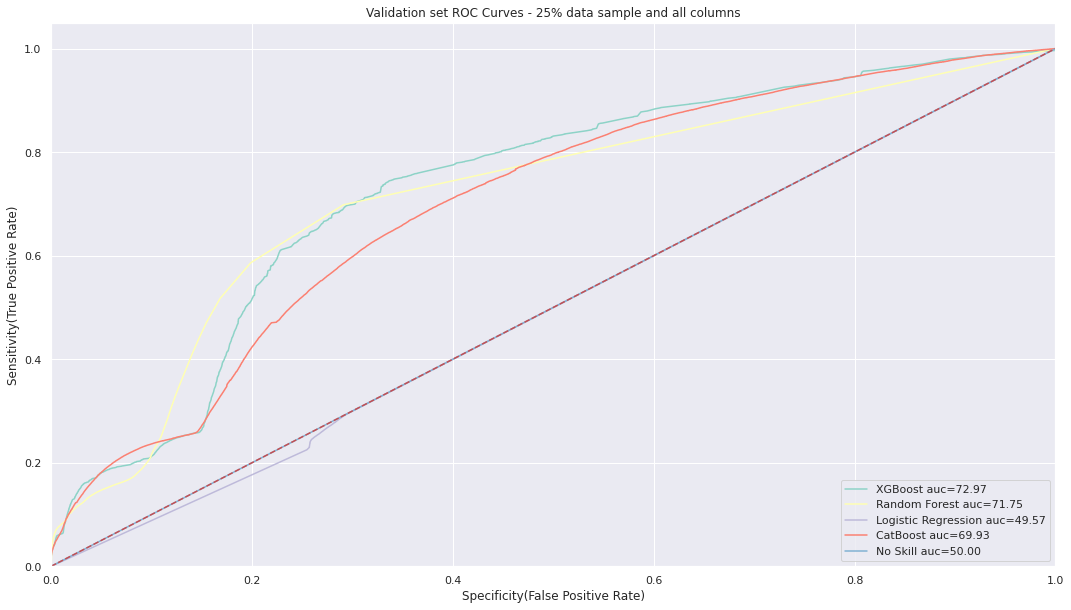

In [82]:
plt.figure(figsize=(18, 10))
for x in predictions_val:
  label, prediction = x['label'], x['prediction']
  fpr, tpr, thresholds = roc_curve(y_val, prediction)
  auc = roc_auc_score(y_val, prediction) * 100
  plt.plot(fpr, tpr, label='%s auc=%0.2f' % (label, auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Validation set ROC Curves - 25% data sample and all columns')
plt.legend(loc="lower right")
plt.show()